In [1]:
%matplotlib inline

In [2]:
from sparapy.radiosity_fast import DRadiosityFast
from sparapy.radiosity import Radiosity
import sparapy.geometry as geo
import sparapy as sp
import cProfile
from datetime import datetime


sample_walls = [
    geo.Polygon(
        [[0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1]],
        [1, 0, 0], [0, 1, 0]),
    geo.Polygon(
        [[0, 1, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]],
        [1, 0, 0], [0, -1, 0]),
    geo.Polygon(
        [[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]],
        [1, 0, 0], [0, 0, 1]),
    geo.Polygon(
        [[0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]],
        [1, 0, 0], [0, 0, -1]),
    geo.Polygon(
        [[0, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0]],
        [0, 0, 1], [1, 0, 0]),
    geo.Polygon(
        [[1, 0, 0], [1, 0, 1], [1, 1, 1], [1, 1, 0]],
        [0, 0, 1], [-1, 0, 0]),
]




In [3]:

cProfile.run('radiosity = DRadiosityFast.from_polygon(sample_walls, 0.005)', )

/Users/anne/git/_pyfar/sparapy/sparapy/geometry.py:14: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


         480375 function calls in 0.623 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen codecs>:260(__init__)
        1    0.000    0.000    0.000    0.000 <frozen codecs>:309(__init__)
        3    0.000    0.000    0.000    0.000 <frozen codecs>:319(decode)
        1    0.003    0.003    0.623    0.623 <string>:1(<module>)
        7    0.000    0.000    0.000    0.000 fromnumeric.py:2172(_sum_dispatcher)
        7    0.000    0.000    0.012    0.002 fromnumeric.py:2177(sum)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:2687(_max_dispatcher)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:2692(max)
       18    0.000    0.000    0.000    0.000 fromnumeric.py:2831(_min_dispatcher)
       18    0.000    0.000    0.000    0.000 fromnumeric.py:2836(min)
       31    0.000    0.000    0.012    0.000 fromnumeric.py:71(_wrapreduction)
       31    0

In [4]:
# first call it need to compline, thats why its a bit slower
# and this is parallelized
start = datetime.now()
cProfile.run('(energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])', )
first_fast = datetime.now() - start

         3186896 function calls (2960922 primitive calls) in 0.954 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:262(__subclasshook__)
       53    0.000    0.000    0.000    0.000 <frozen _collections_abc>:315(__subclasshook__)
        4    0.000    0.000    0.000    0.000 <frozen _collections_abc>:409(__subclasshook__)
        2    0.000    0.000    0.000    0.000 <frozen _collections_abc>:78(_check_methods)
        6    0.000    0.000    0.000    0.000 <frozen _collections_abc>:786(keys)
       12    0.000    0.000    0.000    0.000 <frozen _collections_abc>:790(items)
       18    0.000    0.000    0.000    0.000 <frozen _collections_abc>:812(__init__)
        6    0.000    0.000    0.000    0.000 <frozen _collections_abc>:815(__len__)
       32    0.000    0.000    0.000    0.000 <frozen _collections_abc>:835(__iter__)
      392    0.000    0.000

In [5]:
# second time its very fast since its already compiled
# without numda it took 0.76s no its 0.030s on my machine
start = datetime.now()
cProfile.run('(energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])', )
second_fast = datetime.now() - start

         42 function calls in 0.002 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 functools.py:818(dispatch)
        4    0.000    0.000    0.000    0.000 functools.py:904(wrapper)
        1    0.000    0.000    0.002    0.002 radiosity_fast.py:121(init_energy)
        1    0.000    0.000    0.000    0.000 radiosity_fast.py:173(patches_center)
        1    0.000    0.000    0.000    0.000 radiosity_fast.py:178(patches_size)
        1    0.000    0.000    0.000    0.000 radiosity_fast.py:188(patches_normal)
        1    0.002    0.002    0.002    0.002 radiosity_fast.py:203(calculate_init_energy)
        2    0.000    0.000    0.000    0.000 serialize.py:30(_numba_unpickle)
        4    0.000    0.000    0.000    0.000 typeof.py:120(_typeof_float

In [6]:
# Lets try the initial implementation
cProfile.run('radiosity_old = Radiosity(sample_walls, 0.005, 0, 1)')

/Users/anne/git/_pyfar/sparapy/sparapy/geometry.py:14: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


         46575965 function calls in 15.499 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   15.499   15.499 <string>:1(<module>)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:2687(_max_dispatcher)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:2692(max)
       18    0.000    0.000    0.000    0.000 fromnumeric.py:2831(_min_dispatcher)
       18    0.000    0.000    0.000    0.000 fromnumeric.py:2836(min)
       24    0.000    0.000    0.000    0.000 fromnumeric.py:71(_wrapreduction)
       24    0.000    0.000    0.000    0.000 fromnumeric.py:72(<dictcomp>)
   240006    0.020    0.000    0.020    0.000 geometry.py:122(normal)
        6    0.000    0.000    0.000    0.000 geometry.py:13(<listcomp>)
   480012    0.047    0.000    0.047    0.000 geometry.py:142(n_points)
   240006    0.058    0.000    0.073    0.000 geometry.py:301(_cmp_floats)
   480012    0.590    0.0

In [7]:
def init_energy(rad, source_pos):
    source = geo.SoundSource(source_pos, [1, 0, 0], [0, 0, 1])
    E_matrix = []
    for patches in rad.patch_list:
        patches.init_energy_exchange(
            rad.max_order_k, rad.ir_length_s, source,
            sampling_rate=rad.sampling_rate)
        E_matrix.append(patches.E_matrix)
    return E_matrix

start = datetime.now()
cProfile.run('E_matrix = init_energy(radiosity_old, [0.5, 0.5, 0.5])')
slow = datetime.now() - start

         16320035 function calls in 8.842 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.842    8.842 1159081370.py:1(init_energy)
        1    0.000    0.000    8.842    8.842 <string>:1(<module>)
   960000    0.059    0.000    0.059    0.000 fromnumeric.py:2172(_sum_dispatcher)
   960000    0.385    0.000    1.929    0.000 fromnumeric.py:2177(sum)
   960000    0.472    0.000    1.491    0.000 fromnumeric.py:71(_wrapreduction)
   960000    0.236    0.000    0.236    0.000 fromnumeric.py:72(<dictcomp>)
   480000    0.049    0.000    0.049    0.000 geometry.py:122(normal)
   720000    0.144    0.000    1.914    0.000 geometry.py:127(size)
   960000    0.146    0.000    3.546    0.000 geometry.py:137(center)
   960000    1.195    0.000    3.400    0.000 geometry.py:45(calculate_center)
   720000    1.298    0.000    1.770    0.000 geometry.py:49(calculate_size)
   240000    0.034    0.000    

In [8]:
print(f'number of patches: {radiosity.n_patches}')
print(f'{slow/first_fast} faster than the old implementation (first call)')
print(f'{slow/second_fast} faster than the old implementation (second call)')

number of patches: 240000
8.758764518384837 faster than the old implementation (first call)
3988.5841226883176 faster than the old implementation (second call)


In [9]:
import numpy as np
max_sizes = np.array([0.5, 0.1, 0.05, 0.01, 0.005])
# max_sizes = np.array([0.1, 0.01])
fast_first = np.zeros_like(max_sizes)
fast_second = np.zeros_like(max_sizes)
slow = np.zeros_like(max_sizes)
number_of_patches = np.zeros_like(max_sizes)
repeat = 10
for i, max_size in enumerate(max_sizes):
    print(f'run: {max_size}')
    # run fast two times
    radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)
    start = datetime.now()
    (energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])
    fast_first[i] = (datetime.now() - start).microseconds
    start = datetime.now()
    for _ in range(repeat):
        (energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])
    fast_second[i] = (datetime.now() - start).microseconds/repeat
    number_of_patches[i] = radiosity.n_patches
    # Run old
    radiosity_old = Radiosity(sample_walls, max_size, 0, 1)
    start = datetime.now()
    for _ in range(repeat):
        E_matrix = init_energy(radiosity_old, [0.5, 0.5, 0.5])
    slow[i] = (datetime.now() - start).microseconds/repeat

run: 0.5
run: 0.1
run: 0.05
run: 0.01
run: 0.005


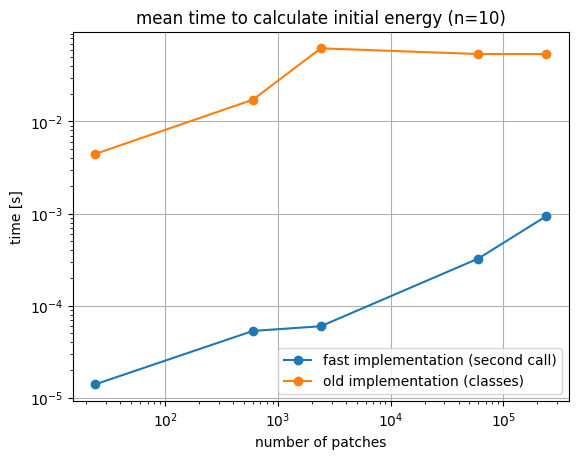

In [11]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.gca()
# ax.semilogy(number_of_patches, fast_first*1e-6, label='fast implementation (first call)')
ax.semilogy(number_of_patches, fast_second*1e-6, label='fast implementation (second call)', marker='o')
ax.semilogy(number_of_patches, slow*1e-6, label='old implementation (classes)', marker='o')
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('number of patches')
ax.set_ylabel('time [s]')
ax.set_title(f'mean time to calculate initial energy (n={repeat})')
plt.legend()